# Comparing methods for classifying word sense definitions


## Task

The task is to classify word sense definitions into coarse semantic categories named "hypersenses".

In this lab, the objective is to explore several ways of using LLMs for this task.


## Data

We will use a dataset of manually labeled word senses, adapted from [(Barque et al., 2020)](https://aclanthology.org/2020.lrec-1.724/) by N. Angleraud in his M2 internship.

These word senses were labeled with a "supersense", each supersense corresponding to a broader "hypersense".

In [ ]:
import pandas as pd
import gzip
import os
import matplotlib.pyplot as plt

def download_and_load_tsv_gz(url):
  """Downloads a gzipped TSV file and loads it into a pandas DataFrame.
  Args:
    url: The URL of the gzipped TSV file.

  Returns:
    A pandas DataFrame containing the data from the file.
  """
  filename = url.split('/')[-1]
  if not os.path.exists(filename):
    !wget "$url"
  else:
    print(f"File '{filename}' already exists. Skipping download.")

  with gzip.open(filename, 'rt', encoding='utf-8') as f:
    df = pd.read_csv(f, sep='\t')

  return df


url = 'http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/super_wiktionary_labeled_data_simplified.noex.25labels.tsv.gz'

try:
  df = download_and_load_tsv_gz(url)
  print("DataFrame loaded successfully.")
  print(df.head())  # Display the first few rows
except Exception as e:
  print(f"Error loading DataFrame: {e}")

### Distribution of supersenses

<Axes: xlabel='supersense'>

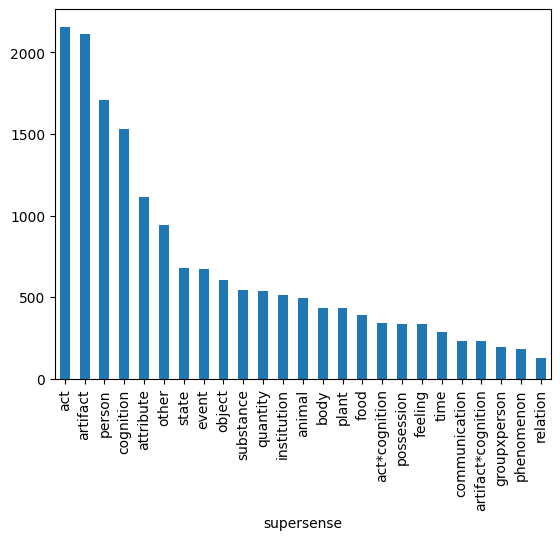

In [ ]:
df['supersense'].value_counts().plot(kind='bar')

### Distribution of hypersenses

In [ ]:
supersenses = df['supersense'].unique()
super2hyper = {'artifact': 'inanimate',
               'body': 'inanimate',
               'food': 'inanimate',
               'object': 'inanimate',
               'plant': 'inanimate',
               'substance': 'inanimate',
               'act':  'dynamic_situation',
               'event': 'dynamic_situation',
               'phenomenon': 'dynamic_situation',
               'animal': 'animate',
               'person': 'animate',
               'groupxperson': 'animate',
               'cognition': 'information',
               'communication': 'information',
               'quantity': 'quantity',
               'attribute': 'stative_situation',
               'feeling': 'stative_situation',
               'relation': 'stative_situation',
               'state': 'stative_situation',
               'time': 'time',
               'possession': 'possession',
               'institution': 'institution',
               'act*cognition': 'dynamic_situation*information',
               'artifact*cognition': 'inanimate*information',
               'other': 'other',
               }


<Axes: xlabel='hypersense'>

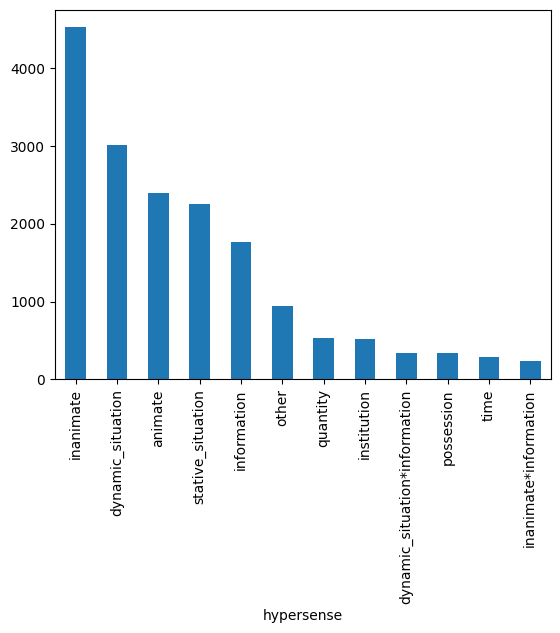

In [ ]:
df['hypersense'] = df['supersense'].map(super2hyper)
df['hypersense'].value_counts().plot(kind='bar')

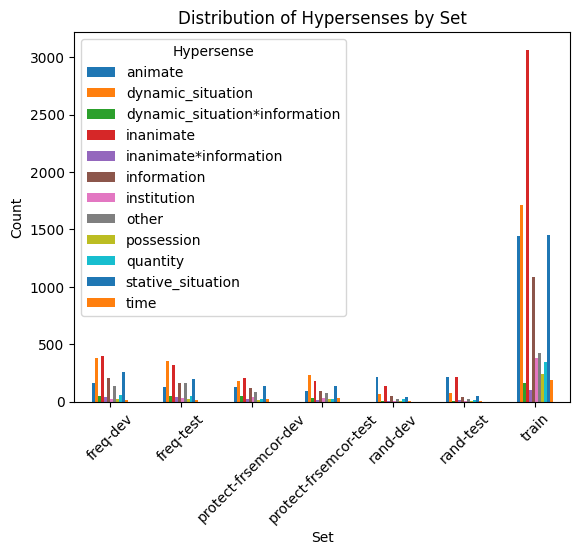

In [ ]:
# PB: note the distribution in the training set, dev and test sets are quite different

df.groupby('set')['hypersense'].value_counts().unstack().plot(kind='bar')
plt.title('Distribution of Hypersenses by Set')
plt.xlabel('Set')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Hypersense')
plt.show()

## Classifiers

Comparing
1. a small LLM fine-tuned for instructions with in-context learning

2. parameter-efficient fine-tuning of LoRA on the full training set



---



# Simple Baseline

https://huggingface.co/microsoft/Phi-3-mini-4k-instruct

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0) # set a specific seed to generate the same set of numbers every time we run the code
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
) #  load the model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct") # load the tokenizer

hypersenses = ", ".join(set(df["hypersense"].unique())) # str, string containing the possible hypersenses to put in the prompt

messages = [
    {"role": "system", "content": "You are an expert linguist of Semantics."},
    {"role": "user", "content": f"Word:'webcaméra', Definition: 'Synonyme de webcam.', Hypersenses: {hypersenses}. From these hypersenses, which one 'webcaméra' belongs to ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "inanimate"},
    {"role": "user", "content": f"Word:'agroécologie', Definition: 'Pratique ou mode de production agricole appliquant les principes de l’agroécologie.', Hypersenses: {hypersenses}. From these hypersenses, which one 'agroécologie' belongs to ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "dynamic_situation"},
    {"role": "user", "content": f"Word:'Reguinois', Definition: 'Habitant de Réguiny, commune française située dans le département du Morbihan.', Hypersenses: {hypersenses}. From these hypersenses, which one 'Reguinois' belongs to ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "animate"},
] # few-shot prompting

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
) # loading the pipeline for text-generation

generation_args = {
    "max_new_tokens": 50, # set the maximum number of tokens generated in an answer
    "return_full_text": False, # don't return the beginning of the prompt (text in messages) when generating text
    "do_sample": False, # do no sample words in the probability distribution when generating text, do greedy decoding
}

In [ ]:
# messages: list[dict[str:str]], contains the instructions for the model
def predict_hypersense(messages, lemma, definition):
  current_messages = messages.copy() # copy messages
  # message2add: dict, the message used as the user input
  message2add = {"role": "user", "content": f"Word:'{lemma}', Definition: '{definition}', Hypersenses: {hypersenses}. From these hypersenses, which one '{lemma}' belongs to ? Answer only the hypersence without additional information"}
  current_messages.append(message2add)
  output = pipe(current_messages, **generation_args)
  return output[0]['generated_text'].strip() # we only generate one sentence because we are using greedy decoding, so access it with output[0], then from the dictionnary extract the generated text

In [ ]:
# filter out the examples used for few-shot learning
df = df[~df["lemma"].isin({"Reguinois", "webcaméra", "agroécologie"})]
test_df = df[df["set"] == "rand-test"] # we are using rand-test as the test set

In [ ]:
baseline_test_df = test_df.copy()
baseline_test_df["hypersense_prediction"] = baseline_test_df.apply(lambda row: predict_hypersense(messages, row["lemma"], row["definition"]), axis=1)

### Accuracy

In [ ]:
# although we start by computing accuracy, f-score might be a better metric since there is a high class imbalance (see F-Score section below)
def compute_accuracy(df_with_pred):
  # add column with bool values (True if prediction is correct, False otherwise)
  df_with_pred["pred_is_correct"] = df_with_pred.apply(
      lambda row: row["hypersense_prediction"].strip() == row["hypersense"], axis=1
  )

  # True = 1, False = 0 (by default) so mean() gets the accuracy
  accuracy = df_with_pred["pred_is_correct"].mean()

  return accuracy

In [ ]:
print(f"Baseline accuracy: {compute_accuracy(baseline_test_df)}")

Baseline accuracy: 0.7159763313609467


### F1 score

In [ ]:
from sklearn.metrics import f1_score

def compute_f_score(df_with_pred):
  return f1_score(df_with_pred['hypersense'], df_with_pred['hypersense_prediction'], average="weighted")

In [ ]:
print(f"Baseline f1 score: {compute_f_score(baseline_test_df)}")

Baseline f1 score: 0.6795089955192883


## Error Analysis

In [ ]:
dev_df = df[df["set"] == "rand-dev"] # We are using rand-dev as the dev set

In [ ]:
baseline_dev_df = dev_df.copy()
baseline_dev_df["hypersense_prediction"] = baseline_dev_df.apply(lambda row: predict_hypersense(messages, row["lemma"], row["definition"]), axis=1)

<hr>

In [ ]:
# save results
baseline_test_df.to_csv("baseline_test_df.csv", index=False)
baseline_dev_df.to_csv("baseline_dev_df.csv", index=False)

## Accuracy for each class

In [ ]:
baseline_dev_df.groupby("hypersense")["pred_is_correct"].mean().reset_index() # "pred_is_correct" is a column in the dataframe wih bool values, True id the gold and predicted hypersense are the same, False otherwise, True = 1, False = 0 (by default) so mean() gets the accuracy
# reset_index(), turn the resulting series into a DataFrame

,hypersense,pred_is_correct
0,animate,0.820276
1,dynamic_situation,0.796875
2,dynamic_situation*information,0.000000
3,inanimate,0.911765
4,inanimate*information,0.000000
5,information,0.078431
6,institution,0.666667
7,other,0.000000
8,possession,0.000000
9,quantity,0.100000


The minority classes are not well predicted

## Checking if there are predicted classes not part of the possible gold classes

In [ ]:
baseline_incorrect_df = baseline_dev_df[~baseline_dev_df["pred_is_correct"]].reset_index()

In [ ]:
# shows rows where the hypersense prediction is not one of the gold hypersenses
baseline_incorrect_df[~baseline_incorrect_df["hypersense_prediction"].isin(set(df["hypersense"].unique()))]

,index,sense_id,entry_id,lemma,nb_occ_lemma_frsemcor,supersense,set,definition,hypersense,hypersense_prediction,pred_is_correct


The model always predicts one of the possible gold classes, so using a Verbalizer is not usefull.

## Confusion Matrix

<Axes: xlabel='hypersense_prediction', ylabel='hypersense'>

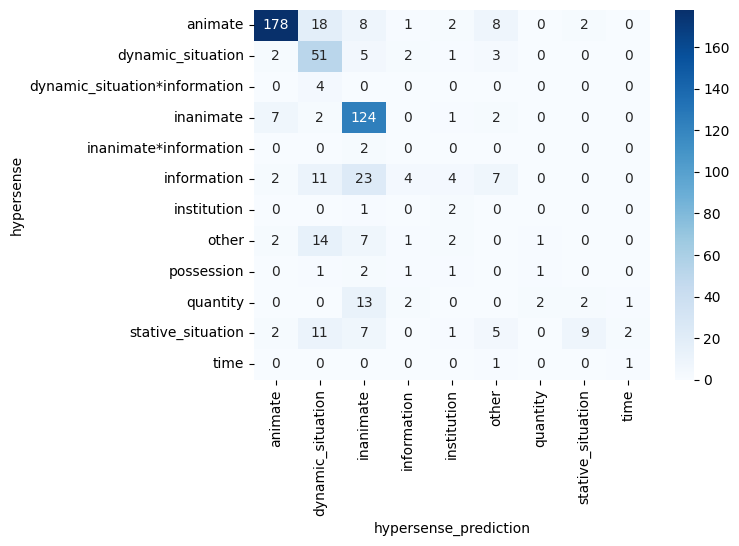

In [ ]:
import seaborn as sns

# pd.crossttab: computes a frequency table of the gold and predicted hypersenses
confusion_matrix = pd.crosstab(baseline_dev_df['hypersense'], baseline_dev_df['hypersense_prediction'])

# plot the frequency table using seaborn, with annotation in the form of integers with the Blues color scheme
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')


*   The model predicted badly the minority classes
*   The model has a clear preference to predict inanimate and dynamic_situation

## Checking Examples of Errors

### Animate predicted as Inanimate

In [ ]:
animate_pred_inanimate_df = baseline_incorrect_df[(baseline_incorrect_df["hypersense"] == "animate") & (baseline_incorrect_df["hypersense_prediction"] == "inanimate")]

<Axes: ylabel='count'>

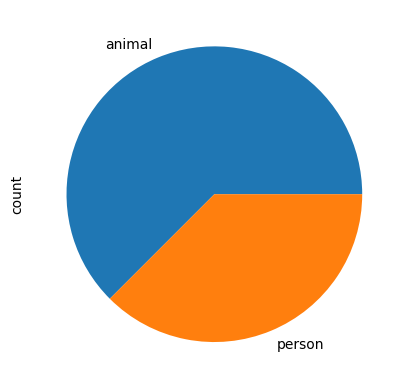

In [ ]:
animate_pred_inanimate_df["supersense"].value_counts().plot(kind="pie")

In [ ]:
animate_correct_df = baseline_dev_df[(baseline_dev_df["hypersense"].str.strip() == "animate") & (baseline_dev_df["hypersense_prediction"].str.strip() == "animate") ]

<Axes: ylabel='count'>

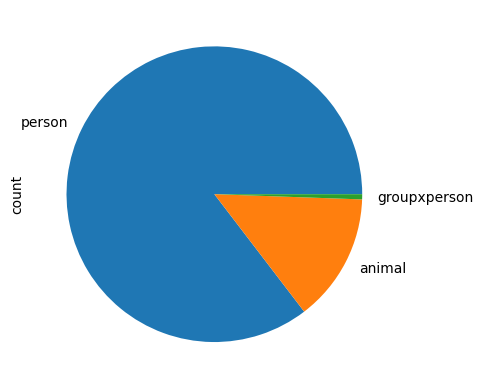

In [ ]:
animate_correct_df["supersense"].value_counts().plot(kind="pie")

When the model predicted an animate as inanimate, the word to classify was more frequently related to an animal then a person. This may happen since the model was trained on English and English uses the pronoun "it" to refer to animals, which can be interprete as inanimate. The model may have thus a bias and deduce that animals should be considered as inanimates.

## Possible Solutions

*   Add more examples from more classes in the prompt to see if the model behaves better, especially for minority classes that were badly predicted (see (1) in messages)
*   Add extra examples to pay attention to when the model makes a reasoning mistake. (see (2) in messages)

# Improved method: making a better prompt

In [ ]:
messages = [
    {"role": "system", "content": "You are an expert linguist of Semantics."},
    {"role": "user", "content": f"Word:'webcaméra', Definition: 'Synonyme de webcam.', Hypersenses: {hypersenses}. From these hypersenses, which one 'webcaméra' belongs to ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "inanimate"},
    {"role": "user", "content": f"Word:'agroécologie', Definition: 'Pratique ou mode de production agricole appliquant les principes de l’agroécologie.', Hypersenses: {hypersenses}. From these hypersenses, which one 'agroécologie' belongs to ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "dynamic_situation"},
    {"role": "user", "content": f"Word:'Reguinois', Definition: 'Habitant de Réguiny, commune française située dans le département du Morbihan.', Hypersenses: {hypersenses}. From these hypersenses, which one 'Reguinois' belongs to ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "animate"},
    {"role": "user", "content": f"Word:'oisillon', Definition: 'Petit oiseau.', Hypersenses: {hypersenses}. From these hypersenses, which one 'oisillon' belongs to, keeping in mind that animals are alive ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "animate"}, # (2) added animal example and explained that animals should be considered as animates
    {"role": "user", "content": f"Word:'héritage', Definition: 'Ce qui se transmet, au sein d’une famille de génération en génération, ou, plus généralement, de personne à personne.', Hypersenses: {hypersenses}. From these hypersenses, which one 'héritage' belongs to ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "information"}, # (1)
    {"role": "user", "content": f"Word:'proportion', Definition: 'Rapport et convenance des parties entre elles et avec leur tout.', Hypersenses: {hypersenses}. From these hypersenses, which one 'proportion' belongs to ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "quantity"}, # (1)
    {"role": "user", "content": f"Word:'journée', Definition: 'Période de rotation d’une planète sur elle-même, en particulier de la Terre.', Hypersenses: {hypersenses}. From these hypersenses, which one 'journée' belongs to ? Answer only the hypersence without additional information"},
    {"role": "assistant", "content": "time"} # (1)
]

In [ ]:
improved_test_df = test_df.copy()

In [ ]:
# make sure the examples used in the prompt are not in the test dataframe
improved_test_df[improved_test_df["lemma"].isin({"webcaméra","héritage","proportion","journée","agroécologie","Reguinois", "oisillon"})]

,sense_id,entry_id,lemma,nb_occ_lemma_frsemcor,supersense,set,definition,hypersense


the test df does not contain the examples used as few-shot prompting



---



In [ ]:
improved_test_df["hypersense_prediction"] = improved_test_df.apply(lambda row: predict_hypersense(messages, row["lemma"], row["definition"]), axis=1)
print(f"Improved prompt accuracy: {compute_accuracy(improved_test_df)}")

Improved prompt accuracy: 0.6671597633136095


In [ ]:
print(f"Improved prompt f-score: {compute_f_score(improved_test_df)}")

Improved prompt f-score: 0.6718995552014357




---



In [ ]:
improved_dev_df = dev_df.copy()

In [ ]:
# make sure the examples used in the prompt are not in the dev dataframe
improved_dev_df[improved_dev_df["lemma"].isin({"webcaméra","héritage","proportion","journée","agroécologie","Reguinois", "oisillon"})]

,sense_id,entry_id,lemma,nb_occ_lemma_frsemcor,supersense,set,definition,hypersense


In [ ]:
improved_dev_df["hypersense_prediction"] = improved_dev_df.apply(lambda row: predict_hypersense(messages, row["lemma"], row["definition"]), axis=1)

In [ ]:
# save results
improved_test_df.to_csv("improved_test_df.csv", index=False)
improved_dev_df.to_csv("improved_dev_df.csv", index=False)

## Accuracy for each class

In [ ]:
baseline_test_df.groupby("hypersense")["pred_is_correct"].mean().reset_index()

,hypersense,pred_is_correct
0,animate,0.876147
1,dynamic_situation,0.789474
2,dynamic_situation*information,0.000000
3,inanimate,0.929577
4,inanimate*information,0.000000
5,information,0.177778
6,institution,0.714286
7,other,0.076923
8,possession,0.000000
9,quantity,0.000000


In [ ]:
improved_test_df.groupby("hypersense")["pred_is_correct"].mean().reset_index()

,hypersense,pred_is_correct
0,animate,0.779817
1,dynamic_situation,0.552632
2,dynamic_situation*information,0.000000
3,inanimate,0.873239
4,inanimate*information,0.000000
5,information,0.444444
6,institution,0.857143
7,other,0.038462
8,possession,0.000000
9,quantity,0.214286


The overall accuracy is worse mainly because the accuracy of the most frequent classes, animate and inanimate, are worse. However, since more examples of minority classes were added in the prompt, the accuracy of the minority classes is better. (quantity, information)

## Confusion Matrix (used the dev set for error analysis)

#### Baseline

<Axes: xlabel='hypersense_prediction', ylabel='hypersense'>

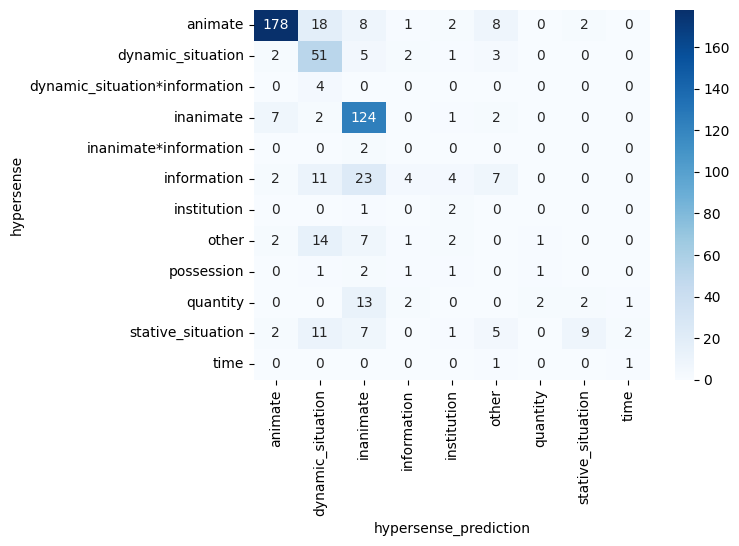

In [ ]:
confusion_matrix = pd.crosstab(baseline_dev_df['hypersense'], baseline_dev_df['hypersense_prediction'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

#### Improved Prompt

<Axes: xlabel='hypersense_prediction', ylabel='hypersense'>

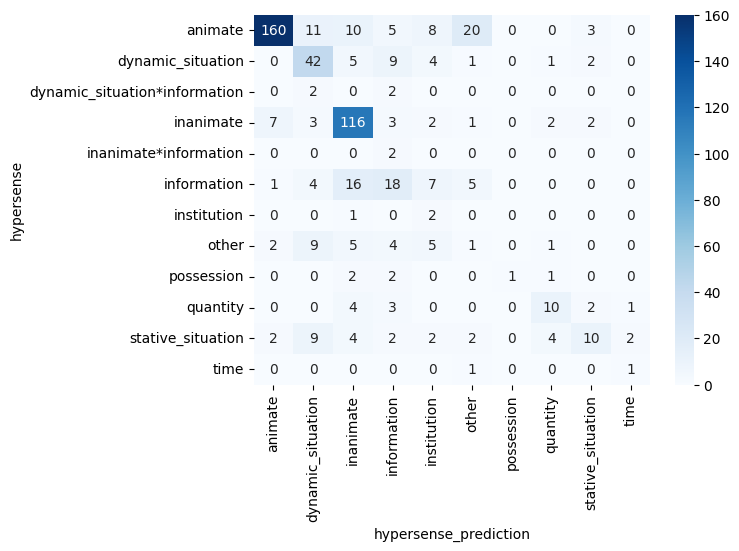

In [ ]:
confusion_matrix = pd.crosstab(improved_dev_df['hypersense'], improved_dev_df['hypersense_prediction'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

we confirm what we saw in the previous graph, the minority classes were predicted better but the most frequent classes were more badly predicted (the correct predictions for animate, inanimate and dynamic_situation are worse)

### Animate predicted as Inanimate

In [ ]:
baseline_dev_df = pd.read_csv("baseline_dev_df.csv")
improved_dev_df = pd.read_csv("improved_dev_df.csv")

In [ ]:
baseline_acc = compute_accuracy(baseline_dev_df) # to get pred_is_correct column
improved_acc = compute_accuracy(improved_dev_df) # to get pred_is_correct column

In [ ]:
improved_incorrect_df = improved_dev_df[~improved_dev_df["pred_is_correct"]].reset_index()
baseline_incorrect_df = baseline_dev_df[~baseline_dev_df["pred_is_correct"]].reset_index()

In [ ]:
baseline_animate_pred_inanimate_df = baseline_incorrect_df[(baseline_incorrect_df["hypersense"] == "animate")
  & (baseline_incorrect_df["hypersense_prediction"] == "inanimate")]
improved_animate_pred_inanimate_df = improved_incorrect_df[(improved_incorrect_df["hypersense"] == "animate")
  & (improved_incorrect_df["hypersense_prediction"] == "inanimate")]

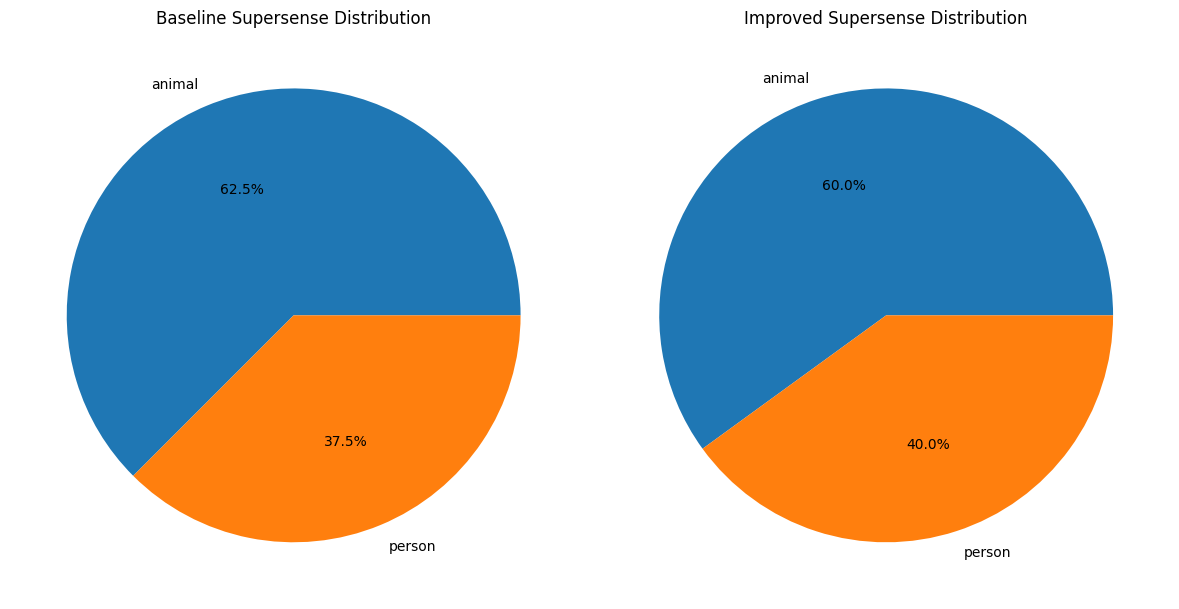

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the baseline pie chart
baseline_animate_pred_inanimate_df["supersense"].value_counts()\
  .plot(kind="pie", ax=axes[0], autopct='%1.1f%%')
axes[0].set_title("Baseline Supersense Distribution")
axes[0].set_ylabel("")  # Remove y-axis label for a cleaner look

# Plot the improved prompt pie chart
improved_animate_pred_inanimate_df["supersense"].value_counts()\
  .plot(kind="pie", ax=axes[1], autopct='%1.1f%%')
axes[1].set_title("Improved Supersense Distribution")
axes[1].set_ylabel("")  # Remove y-axis label for a cleaner look

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

With the improved prompt, among the examples that were animate but were incorrectly predicted as inanimate, a lower proportion of predictions had the supersense animal. However, this difference is very small (2.5%).

As a consequence, adding an example explaining that animals are living beings and not inanimate helped the model to better predict animals as animates, but only a little bit.

## F_score

Baseline F Score:

In [ ]:
f1_score(baseline_test_df['hypersense'], baseline_test_df['hypersense_prediction'], average="weighted") # weighted to account for class imbalance

0.6795089955192883

Improved Prompt:

In [ ]:
f1_score(improved_test_df['hypersense'], improved_test_df['hypersense_prediction'], average="weighted") # weighted to account for class imbalance

0.6718995552014357

The baseline is better since the f-score of the baseline is better than the f-score of the improved prompt.

We added in the prompt an example for the incorrectly predicted minority classes "quantity" "time" and "information". This resulted in these classes being better predited (although for the class time it is hard to see an effect since there is only 2 examples in rand-dev with the gold class time).

However, this lowered the capacity of the model to correctly predict the most frequent classes like animate, inanimate and dynamic-situation.

A better prompt with more representative examples, or including chain-of-thought prompting, might improve the results of improved prompt.